# INTRODUCTION

Bikeshare system is a service in which bicycles are made available for shared use to individuals on a very short term basis. Bike share schemes allow people to borrow a bike from point "A" and return it at point "B" [1]. The New York City has a bikeshare system called *Citibike*. It has 3 ways to become a user of the system, with different costs and benefits:

* 24-hour pass: \$12 and unlimited 30-minute rides.
* 3 or 7 day pass: \$24 and unlimited 30-minute rides.
* Annual membership: \$14.95/month and unlimited 45-minute rides.

The *Annual membership* allows unlimited 45 minutes rides, while the others memberships reduce this to 30 minute rides. Therefore, is important to consider the expected time of the average trip by type of user, as it has meaningful impact in the expected earnings of the company that is providing the service. 

From now one, based on the dataset's metadata, we'll namd the type of users as follow:

* **Customer:**  24-hour pass or 3/7-day pass user
* **Subscriber:** Annual Member

Higher average travel times for *Customers* will imply extra earnings for the company, given that enough of them break the 30 minute barrier.  So, does the *Customers's trips*  on citi bikes last longer than the other *Subscriber's trips*?


# HYPOTHESIS 

### Null Hypothesis  ($H_0$):

The *Customers's trips* average time on citi bikes is *the same or lower* than the average trip time of *Subscriber's trips*, for the month of June 2016.

$$H_0 : \mu_{tripTimeCost} =< \mu_{tripTimeSubs} $$

### Alternative Hypothesis ($H_a$):

$$H_A : \mu_{tripTimeCost} > \mu_{tripTimeSubs} $$

The *Customers's trips* average time on citi bikes is *higher* than the average trip time of *Subscriber's trips*, for the month of June 2016.

### Confidence level: 95%
Significance threshold  $\alpha=0.05$

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import os
import seaborn
import scipy.stats
from scipy.stats import ttest_ind

%matplotlib inline

In [2]:
alpha = 0.5

In [3]:
def getCitiBikeCSV(datestring):
    print ("Downloading", datestring)
    ### First I will heck that it is not already there
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        if os.path.isfile(datestring + "-citibike-tripdata.csv"):
            # if in the current dir just move it
            if os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA")):
                print ("Error moving file!, Please check!")
        #otherwise start looking for the zip file
        else:
            if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip"):
                if not os.path.isfile(datestring + "-citibike-tripdata.zip"):
                    os.system("curl -O https://s3.amazonaws.com/tripdata/" + datestring + "-citibike-tripdata.zip")
                ###  To move it I use the os.system() functions to run bash commands with arguments
                os.system("mv " + datestring + "-citibike-tripdata.zip " + os.getenv("PUIDATA"))
            ### unzip the csv 
            os.system("unzip " + os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip")
            ## NOTE: old csv citibike data had a different name structure. 
            #if is 2014 move the csv file using proper defined file name
            if '2014' in datestring:
                os.system("mv " + datestring[:4] + '-' +  datestring[4:] + 
                          "\ -\ Citi\ Bike\ trip\ data.csv " + datestring + "-citibike-tripdata.csv")
            
            #if is not 2014, move the csv file using the current name structure
            else:
                os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA"))

                
    ### One final check:
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        print ("WARNING!!! something is wrong: the file is not there!")

    else:
        print ("file in place, you can continue")

In [4]:
datestring = '201606'
getCitiBikeCSV(datestring)

('Downloading', '201606')
file in place, you can continue


In [5]:
df = pd.read_csv(os.getenv("PUIDATA") + "/" + datestring + '-citibike-tripdata.csv')
df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,1470,6/1/2016 00:00:18,6/1/2016 00:24:48,380,W 4 St & 7 Ave S,40.734011,-74.002939,3236,W 42 St & Dyer Ave,40.758985,-73.993800,19859,Subscriber,1972.0,1
1,229,6/1/2016 00:00:20,6/1/2016 00:04:09,3092,Berry St & N 8 St,40.719009,-73.958525,3103,N 11 St & Wythe Ave,40.721533,-73.957824,16233,Subscriber,1967.0,1
2,344,6/1/2016 00:00:21,6/1/2016 00:06:06,449,W 52 St & 9 Ave,40.764618,-73.987895,469,Broadway & W 53 St,40.763441,-73.982681,22397,Subscriber,1989.0,1
3,1120,6/1/2016 00:00:28,6/1/2016 00:19:09,522,E 51 St & Lexington Ave,40.757148,-73.972078,401,Allen St & Rivington St,40.720196,-73.989978,16231,Subscriber,1991.0,1
4,229,6/1/2016 00:00:53,6/1/2016 00:04:42,335,Washington Pl & Broadway,40.729039,-73.994046,285,Broadway & E 14 St,40.734546,-73.990741,15400,Subscriber,1989.0,1


Firts, we keep the variable involved in the analysis. The membership type for each trip, and its duration in seconds.

In [6]:
#selecting a subset of data
df = df.loc[:,['usertype','tripduration']]
df.head()

,usertype,tripduration
0,Subscriber,1470
1,Subscriber,229
2,Subscriber,344
3,Subscriber,1120
4,Subscriber,229


In [7]:
df.usertype.value_counts()

Subscriber    1303486
Customer       156832
Name: usertype, dtype: int64

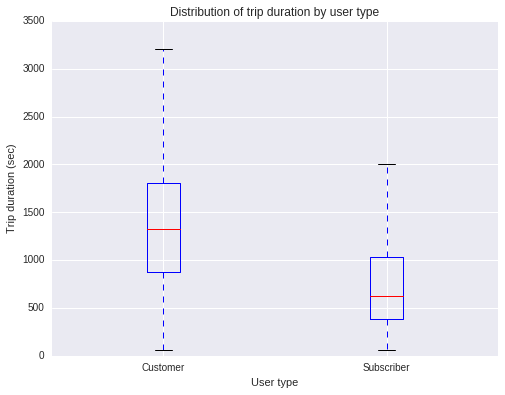

In [38]:
#plt.boxplot(df['tripduration'], 0, '')
customerData = df['tripduration'][df['usertype']=='Customer']
suscriberData = df['tripduration'][df['usertype']=='Subscriber']
dataPlot = [customerData,suscriberData]


# Create a figure instance
fig = plt.figure(figsize=(8, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
ax.boxplot(dataPlot, 0, '')
ax.set_xticklabels(['Customer', 'Subscriber'])
ax.set_ylabel('Trip duration (sec)')
ax.set_xlabel('User type')
ax.set_title("Distribution of trip duration by user type")

### Figure 2
Boxplot of trip duration by subscription type, showing median, interquartile range and full distribution of trip durations. As shown, the median of the *Customer's trip* duration is higher than the *Subscriber's*"

In [9]:
medianTripCust = df['tripduration'].groupby(df['usertype']).median()['Customer']
medianTripSubs = df['tripduration'].groupby(df['usertype']).median()['Subscriber']

print "Customer's median trip duration" , str(datetime.timedelta(seconds=medianTripCust))
print "Subscriber's median trip duration" , str(datetime.timedelta(seconds=medianTripSubs))


Customer's median trip duration 0:22:03
Subscriber's median trip duration 0:10:25


In a first exploratory analysis of the data, we can say there are 1,303,486 Subscribers while only 156,832 Customers. Also, taking the median, the Customer's trip is higher. But is necessary to take into  consideration the mean of the trip. 

In [10]:
meanTripCust = df['tripduration'].groupby(df['usertype']).mean()['Customer']
meanTripSubs = df['tripduration'].groupby(df['usertype']).mean()['Subscriber']

print "Customer's mean trip duration" , str(datetime.timedelta(seconds=meanTripCust))
print "Subscriber's mean trip duration" , str(datetime.timedelta(seconds=meanTripSubs))


Customer's mean trip duration 0:35:52.122233
Subscriber's mean trip duration 0:14:09.905440


First, the *Customer's* mean trup duration is 35 minutes and 52 seconds, breaking the 30 minutes barries, which will imply extra earnings for the company. Also, it's higher than the *Subscriber's*, which is 14 minutes and nearly 10 seconds. Although, to make this affirmation with certain statistical confidence (95%), a statistical test is requiered. Given that we are trying to asses the difference in means with one categorical independent variable and one continuous dependent variable, the *t-Test* is a proper test for this situation. As the t-test perform better for equal sample size we obtain a random sample from the Subscribersdata  with equal sample size than Costumers sample.

In [28]:
#subset of subscribers data
suscriberDfSubset= df[df.usertype == 'Subscriber'].sample(n=len(customerData),random_state = 123)

In [29]:
meanTripCust = df['tripduration'].groupby(df['usertype']).mean()['Customer']
meanTripSubs = suscriberDfSubset['tripduration'].groupby(df['usertype']).mean()['Subscriber']

print "Customer's mean trip duration" , str(datetime.timedelta(seconds=meanTripCust))
print "Subscriber's mean trip duration" , str(datetime.timedelta(seconds=meanTripSubs))

Customer's mean trip duration 0:35:52.122233
Subscriber's mean trip duration 0:14:17.013314


With this new values, now we cant test the difference in means with the *t-test*.

In [30]:
suscriberDfSubset.head()

,usertype,tripduration
954414,Subscriber,159
752668,Subscriber,1107
371363,Subscriber,580
215360,Subscriber,1107
1114779,Subscriber,868


In [34]:
suscriberDataSubset = suscriberDfSubset['tripduration']
t,p = ttest_ind(customerData, suscriberDataSubset)

In [36]:
if (p/2) < alpha:
    print 'We can affirm with statistical confidence of 95% that the diference in the means is significative'
else:
    print 'We can not affirm with statistical confidence of 95% that the diference in the means is significative'

We can affirm with statistical confidence of 95% that the diference in the means is significative


As the test confirms, we can reject the Null Hypothesis and confirm that the *Customers's trips* average time on citi bikes is *higher* than the average trip time of *Subscriber's trips*, for the month of June 2016.

# References
[1] Wikipedia https://en.wikipedia.org/wiki/Bicycle-sharing_system